In [ ]:
# NOTE: Some low-level warnings from TensorFlow/XLA (e.g., cuDNN/cuBLAS registration, op-by-op fallback)
# may appear in the output. These messages are harmless and come from compiled C++ libraries.
# They cannot be silenced and do NOT affect training or results — feel free to ignore them.

import tensorflow as tf

Define and initialize key constants and configuration parameters to efficiently handle a dataset of MRI images aimed at detecting Alzheimer’s disease. 

In [3]:
ORIGINAL_DS = "/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/"
PROCESSED_DS = "dataset/"
WIDTH = 176
HEIGHT = 208
BATCH_SIZE = 6000
VALIDATION_SPLIT = 0.2

Since *SMOTE* is being used but the original dataset has to remain unchanged, a copy of the dataset is created on which the necessary modifications will be applied.

In [4]:
import os
from distutils.dir_util import copy_tree, remove_tree

if os.path.exists(PROCESSED_DS):
    remove_tree(PROCESSED_DS)
    
os.makedirs(PROCESSED_DS)
copy_tree(ORIGINAL_DS + "train/", PROCESSED_DS)
copy_tree(ORIGINAL_DS + "test/", PROCESSED_DS)
print("Force not showing files output")

Force not showing files output


Here, a set of images is generated for training by applying data augmentation, specifying brightness adjustments for some images and zoom modifications for others. <br>
For this purpose, *fill_mode="nearest"* is used, which fills pixels beyond the image borders with the value of the nearest pixel.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creates an image generator for training
datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.99, 1.01],
    fill_mode="nearest"
)

In [6]:
# creates a data generator for trainign
train_generator = datagen.flow_from_directory(
    directory=PROCESSED_DS,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

Found 6400 images belonging to 4 classes.


In [7]:
# test data and labels extraction
train_data, train_labels = next(train_generator)

The dataset is extremely imbalanced: specifically, **NonDemented** and **VeryMildDemented** are the majority classes, while the other two are minority classes. <br>
To balance the dataset, *SMOTE* is applied to the training data. <br>
After applying *SMOTE*, the balanced training data is returned to its original form. <br> 
A seed is used for *SMOTE* to ensure reproducible results.

In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
train_data_resampled, train_labels_resampled = smote.fit_resample(train_data.reshape(-1, WIDTH * HEIGHT * 3), train_labels)
train_data_resampled = train_data_resampled.reshape(-1, WIDTH, HEIGHT, 3)

The balanced data and corresponding labels are divided into two sets: one for training and one for validation, using *VALIDATION_SPLIT* as the percentage for the validation set. <br>
The training set is further split to create an internal validation set, in order to improve training performance.

In [9]:
from sklearn.model_selection import train_test_split

# data split into trai, validation and test set
train_data, test_data, train_labels, test_labels = train_test_split(train_data_resampled, train_labels_resampled, test_size=VALIDATION_SPLIT, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=VALIDATION_SPLIT, random_state=42)

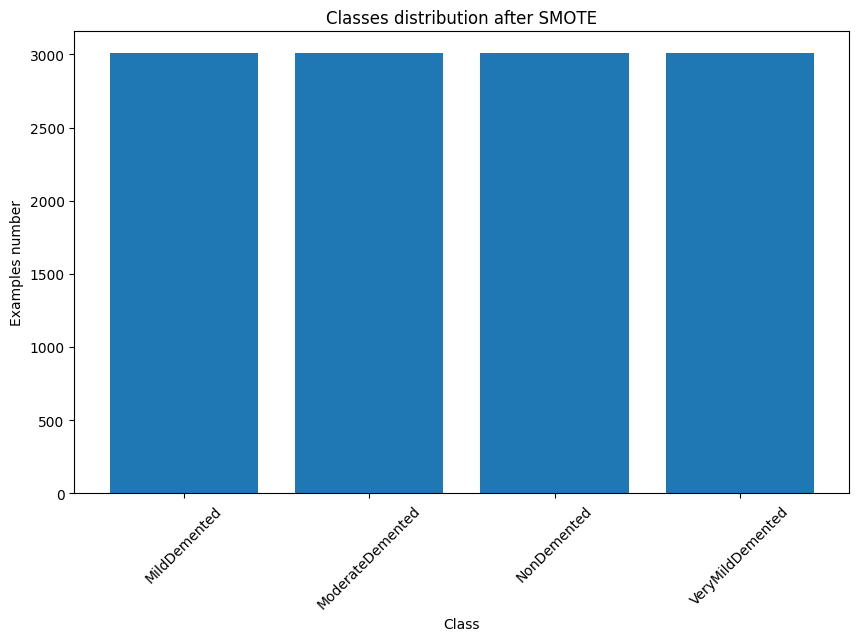

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# gets classes names from generator
class_names = list(train_generator.class_indices.keys())

# counts number of examples for every class after applying SMOTE
unique, counts = np.unique(np.argmax(train_labels_resampled, axis=1), return_counts=True)

# plots the result data after applying SMOTE
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Examples number')
plt.title('Classes distribution after SMOTE')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità
plt.show()


A neural network model is built from scratch, where each convolutional layer is followed by two additional layers: **BatchNormalization**, which helps the network train faster and more stably, and **MaxPooling**, which reduces the image size while retaining only the most important features. <br>
These layers are then flattened into a one-dimensional vector, and two fully connected layers are added. <br>
One of these is the output layer, which has as many neurons as there are classes, while the other includes a Dropout rate of 50% to prevent overfitting. <br>
The activation function of the output layer is **softmax**, allowing the neuron with the highest activation to indicate the most probable class.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax'),
])

The model is then compiled, using a lower *learning_rate* to prevent the weights from being updated too quickly. The **Adam** optimizer and the **categorical_crossentropy** loss function are used, both of which are commonly applied to multi-class classification problems. <br>
The chosen metric is *accuracy*, which measures the percentage of correct predictions made by the model.

In [12]:
from tensorflow.keras.optimizers import Adam

learning_rate = 1e-6 
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 174, 206, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 174, 206, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 87, 103, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 85, 101, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 85, 101, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61440)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    15,728,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,824,068 (60.36 MB)

 Trainable params: 15,823,620 (60.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

EPOCHS = 30
train_info = model.fit(train_data, train_labels,
                    epochs=EPOCHS,
                    validation_data=(val_data, val_labels),
                    callbacks=[early_stopping])

Epoch 1/30
  3/241 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.2170 - loss: 2.6080

I0000 00:00:1751396029.801875     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1751396029.818753     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3389 - loss: 1.9169

W0000 00:00:1751396047.949689     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1751396050.824385     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


241/241 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.3392 - loss: 1.9153 - val_accuracy: 0.3243 - val_loss: 1.4813
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.5706 - loss: 1.0179 - val_accuracy: 0.4314 - val_loss: 1.1574
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6550 - loss: 0.8394 - val_accuracy: 0.7115 - val_loss: 0.7368
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6824 - loss: 0.7423 - val_accuracy: 0.7604 - val_loss: 0.6152
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7126 - loss: 0.6803 - val_accuracy: 0.7859 - val_loss: 0.5673
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7465 - loss: 0.6094 - val_accuracy: 0.8082 - val_loss: 0.5172
Epoch 7/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7771 - loss: 0.5524 - val_accuracy: 0.8228 - val_loss: 0.4816
Epoch 8/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7871 - loss: 0.5204 - val_accurac

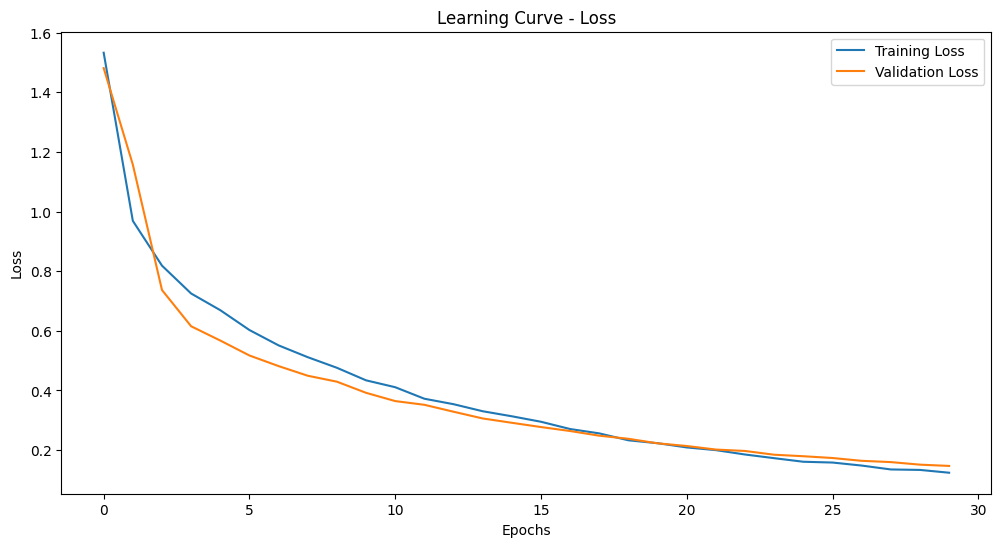

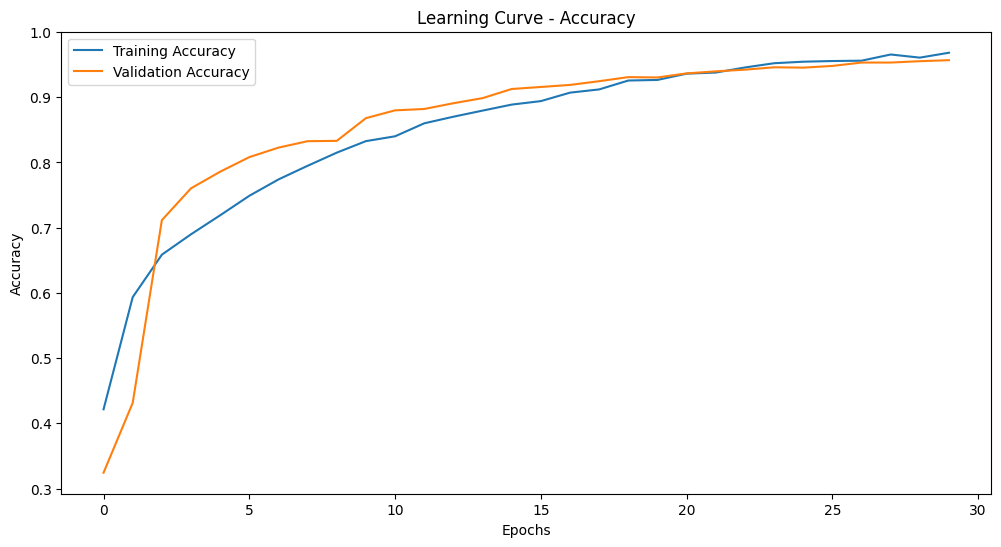

In [14]:
import matplotlib.pyplot as plt

# loss training curve plot
plt.figure(figsize=(12, 6))
plt.plot(train_info.history['loss'], label='Training Loss')
plt.plot(train_info.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()
plt.show()

# accuracy training curve plot
plt.figure(figsize=(12, 6))
plt.plot(train_info.history['accuracy'], label='Training Accuracy')
plt.plot(train_info.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Accuracy')
plt.legend()
plt.show()

Model evaluation using the test set which contains the test images and labels.

In [15]:
test_scores = model.evaluate(test_data, test_labels)
print(f"Testing Accuracy: {test_scores[1] * 100:.2f}%")

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9548 - loss: 0.1534
Testing Accuracy: 95.18%


Predictions are made on the test data, returning an array of class probabilities for each image. Then, an array containing the highest probability for each image is created, which is used to generate a confusion matrix.

17/76 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

W0000 00:00:1751396391.735094     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


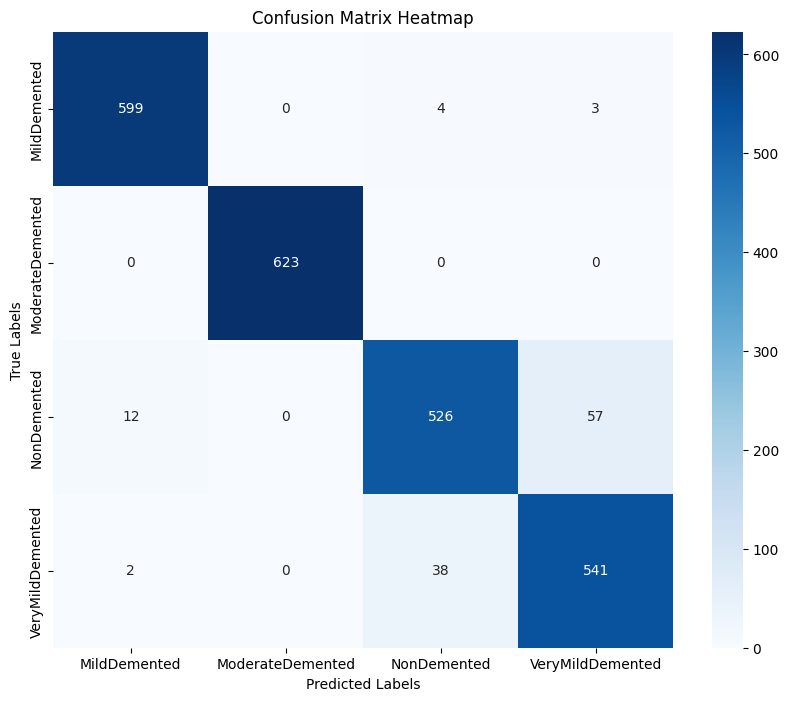

                  precision    recall  f1-score   support

    MildDemented       0.98      0.99      0.98       606
ModerateDemented       1.00      1.00      1.00       623
     NonDemented       0.93      0.88      0.90       595
VeryMildDemented       0.90      0.93      0.92       581

        accuracy                           0.95      2405
       macro avg       0.95      0.95      0.95      2405
    weighted avg       0.95      0.95      0.95      2405



In [16]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

pred_labels = model.predict(test_data)
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)
conf_arr = confusion_matrix(test_ls, pred_ls)

# shows a prediction heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_arr, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

print(classification_report(test_ls, pred_ls, target_names=train_generator.class_indices.keys()))